# Homework 4

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [1]:
# Import the Obspy modules that will be useful to download seismic data
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime


import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [2]:
# answer below
station = 'DR01'
network = 'XH'
channel = 'LHN'
Tstart = UTCDateTime(2015,1,1)
Tend = UTCDateTime(2015,3,31)
fdsn_client = fdsn.Client('IRIS')

Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)

Z.merge(); Z.detrend(type='linear'); Z[0].taper(max_percentage=0.05); Z[0].remove_response()

XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-03-31T00:00:00.000000Z | 1.0 Hz, 7689601 samples

In [3]:
# how many days did we download?
dt=Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

89


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [4]:
# answer below
import scipy.signal as signal
from scipy.signal import butter,buttord,  sosfiltfilt, freqs


# Here we use a Butterworth filter to select the spectral content of the waveform. 
# I like to use Buttord because it finds the order of the filter that meets the amplitude reduction criterion
# it's a lot more intuitive! https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html

fs = Z[0].stats.sampling_rate
z = np.asarray(Z[0].data)


# Lowpass
lowpass_filter = signal.butter(2, 0.01, 'lowpass', fs=fs, output='sos')
z_lowpass = signal.sosfilt(lowpass_filter, z)

# Bandpass
bandpass_filter = signal.butter(2, [0.01,0.1], 'bandpass', fs=fs, output='sos')
z_bandpass = signal.sosfilt(bandpass_filter, z)

# Highpass
highpass_filter = signal.butter(2, 0.1, 'highpass', fs=fs, output='sos')
z_highpass = signal.sosfilt(highpass_filter, Z)


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

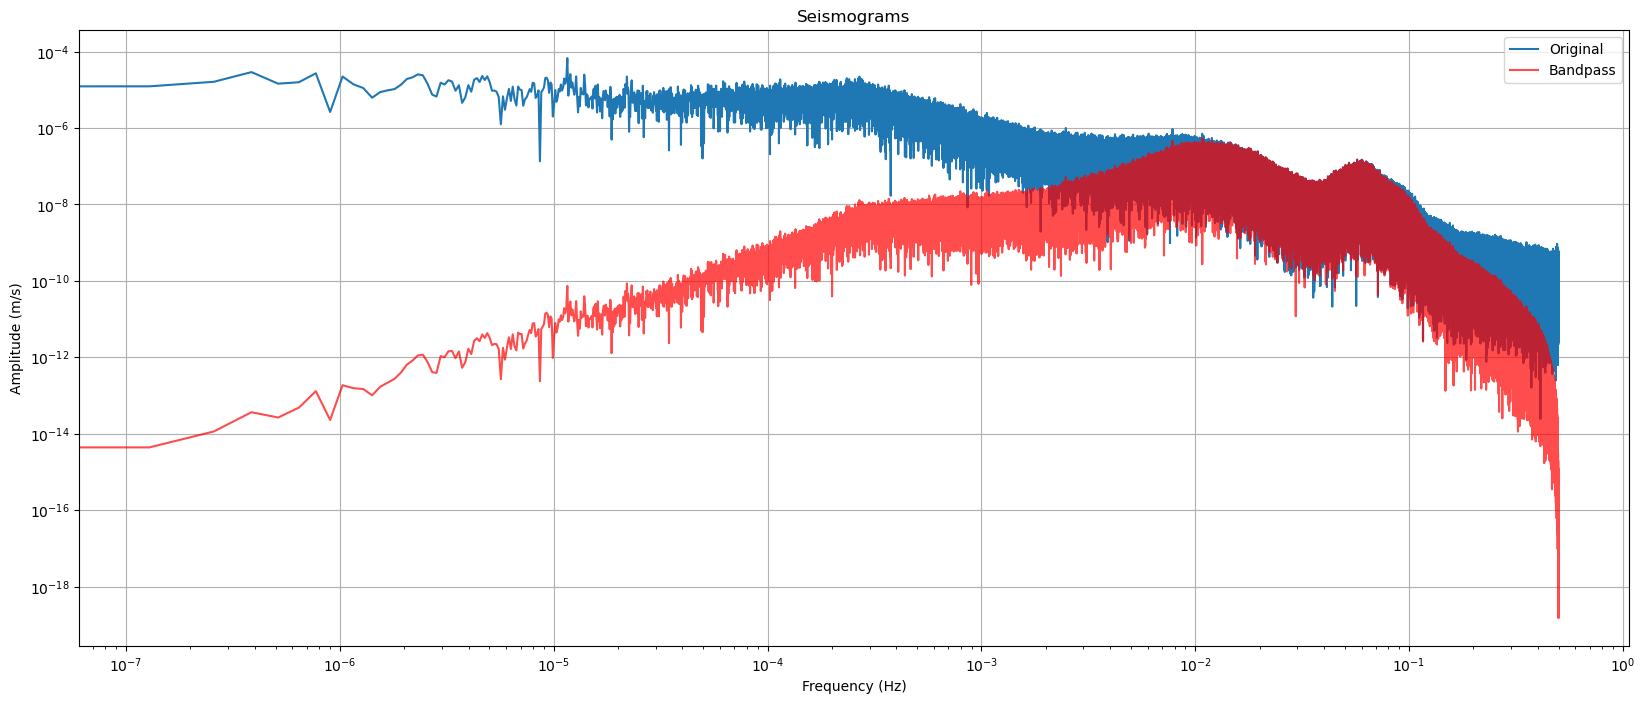

In [5]:
# import FFT modules
# answer below

from scipy.fftpack import fft, ifft, fftfreq, next_fast_len 

npts = Z[0].stats.npts
Nfft = next_fast_len(int(Z[0].data.shape[0]))
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)

bandpass_hat = fft(z_bandpass,n=Nfft)

fig=plt.figure(figsize=(20,8))
plt.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
plt.plot(freqVec,np.abs(bandpass_hat[:Nfft//2])/Nfft, 'r', alpha=0.7)
plt.grid(True)
plt.xscale('log');plt.yscale('log')
plt.xlabel('Frequency (Hz)');plt.ylabel('Amplitude (m/s)')
plt.title('Seismograms')
plt.legend(['Original','Bandpass'])
plt.show()

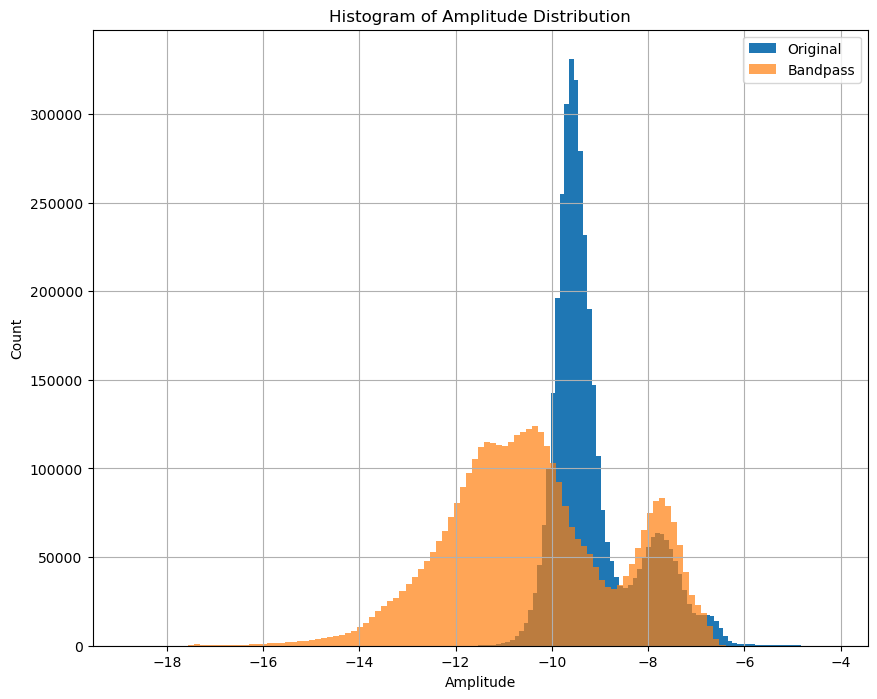

In [6]:
fig = plt.figure(figsize=(10,8))
plt.hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100);plt.grid(True)
plt.hist(np.log10(np.abs(bandpass_hat[:Nfft//2])/Nfft),100, alpha=0.7);plt.grid(True)
plt.xlabel('Amplitude')
plt.ylabel('Count')
plt.title('Histogram of Amplitude Distribution')
plt.legend(['Original','Bandpass'])
plt.show()

Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

As what it is, the bandpass filter retains the signal between 0.01Hz and 0.1Hz. We can observe that it keeps the similar shape as the original seismogram

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

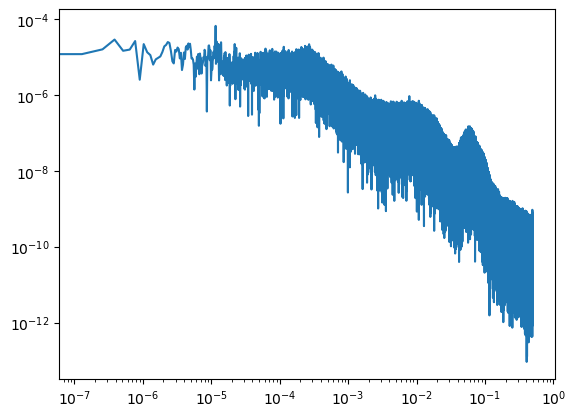

In [7]:

# answer below
from numpy import random
from scipy.fftpack import ifft,ifftshift 

t = np.arange(0., np.size(z), 1./fs)
new_noise = random.uniform(-1, 1, len(t))
Nfft_noise = next_fast_len(int(new_noise.data.shape[0]))
freq_noise = fftfreq(Nfft_noise, d=Z[0].stats.delta)[:Nfft_noise//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft_noise)


plt.plot(freq_noise,np.abs(Zhat[:Nfft_noise//2])/Nfft_noise)
plt.xscale('log')
plt.yscale('log')



**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

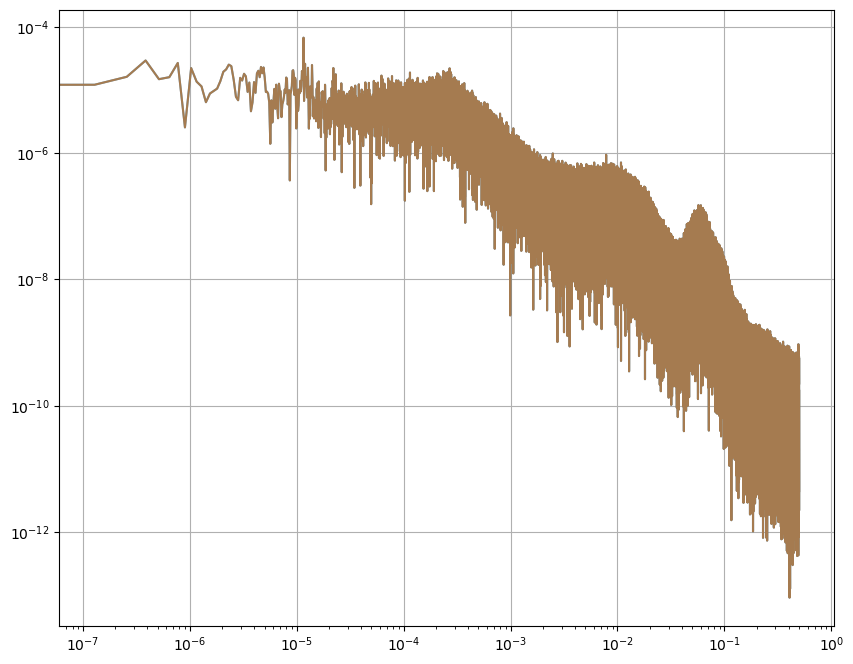

In [8]:
# answer below
fig_check = plt.figure(figsize=(10,8))
plt.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
plt.plot(freq_noise,np.abs(Zhat[:Nfft_noise//2])/Nfft_noise, alpha = 0.6)

plt.grid(True)
plt.xscale('log')
plt.yscale('log')

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

In [ ]:
# answer below
from scipy.signal import stft
z = np.asarray(Zhat.data)
f, t, Zxx = stft(z, fs = fs, noverlap = 200)
plt.pcolormesh(t, f, np.log(np.abs(Zxx)))
plt.title('STFT magnitute')

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

Text(0.5, 1.0, 'variometric_derived_TEC in first 2 hours')

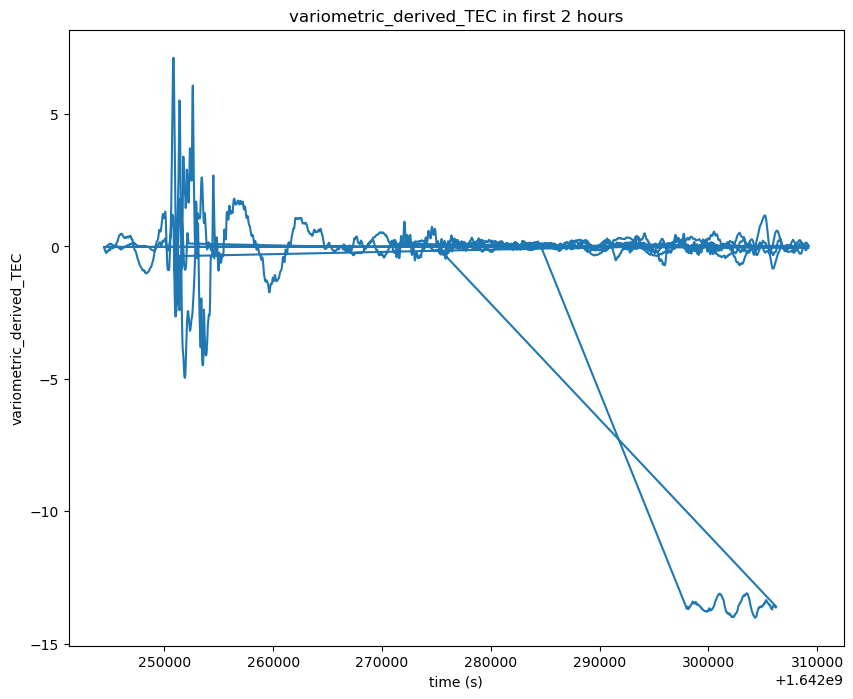

In [11]:
# answer below
filename = "./ioncorr_samo_015_2022_tonga.csv"
data = pd.read_csv(filename)


fig = plt.figure(figsize=(10,8))
plt.plot(data['time'][0:7200], data['variometric_derived_TEC'][0:7200])
plt.xlabel('time (s)'); plt.ylabel('variometric_derived_TEC')
plt.title('variometric_derived_TEC in first 2 hours')

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [47]:
# answer below
station=filename.split("_")[1]
print(station)

samo


## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

Text(0.5, 1.0, 'vTEC filtered for each satellite observation')

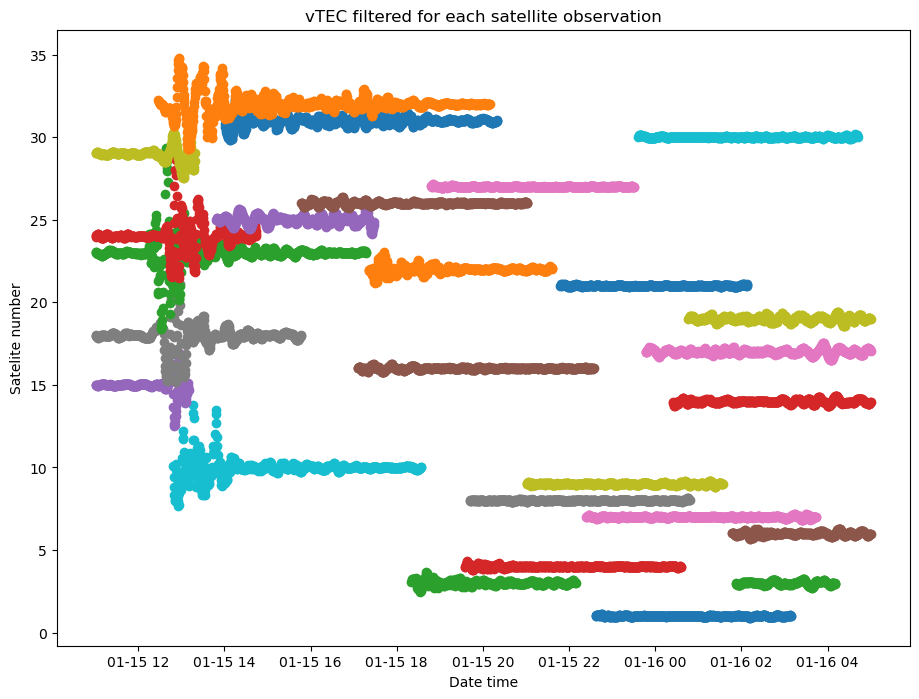

In [14]:
# answer below
fig2 = plt.figure(figsize=(11,8))
for satellite in range (1,33):
    new_data = data[data['satellite_number'] == satellite]
    datetime64 = np.array(new_data['time'], dtype='datetime64[s]')
    plt.plot_date(datetime64, new_data['variometric_derived_TEC_filtered']+new_data['satellite_number'])

plt.xlabel("Date time")
plt.ylabel("Satelite number")
plt.title('vTEC filtered for each satellite observation')


You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. What can you tell about the time-frequency characteristic of these disturbances?

In [67]:
new_data

,Unnamed: 0,GPS_seconds,satellite_number,variometric_derived_TEC,variometric_derived_TEC_filtered,absolute_derived_TEC,absolute_derived_TEC_filtered,latitude_piercing_point,longitude_piercing_point,satellite_azimuth,satellite_elevation_angle,distance_to_piercing_point,time
13465,13465,1.326256e+09,32,-0.102870,0.261472,-1.362190,0.221090,-9.7571,-178.3867,301.99,18.19,1235.51,1.642250e+09
13466,13466,1.326256e+09,32,-0.189655,0.198191,-1.288900,0.202868,-9.8007,-178.3641,301.80,18.33,1230.22,1.642250e+09
13467,13467,1.326256e+09,32,-0.259131,0.145576,-1.267190,0.195076,-9.8440,-178.3418,301.62,18.47,1224.96,1.642250e+09
13468,13468,1.326256e+09,32,-0.325058,0.100337,-1.198110,0.174718,-9.8869,-178.3196,301.43,18.60,1219.76,1.642250e+09
13469,13469,1.326256e+09,32,-0.382771,0.056032,-1.171730,0.151678,-9.9296,-178.2976,301.24,18.74,1214.58,1.642250e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14384,14384,1.326284e+09,32,0.095299,0.002582,0.933815,-0.062063,-9.1089,-165.7879,51.10,18.77,1631.19,1.642277e+09
14385,14385,1.326284e+09,32,0.076074,0.005932,1.045090,-0.034498,-9.0631,-165.7654,50.94,18.61,1636.70,1.642277e+09
14386,14386,1.326284e+09,32,0.096131,0.022571,1.212130,0.005912,-9.0169,-165.7428,50.78,18.46,1642.25,1.642277e+09
14387,14387,1.326284e+09,32,0.093255,0.027523,1.290050,0.029049,-8.9704,-165.7199,50.63,18.30,1647.86,1.642277e+09


In [16]:
# answer below
last_sat = new_data['variometric_derived_TEC_filtered'].values
t = new_data['time'].values
t

array([  1.64224968e+09,   1.64224971e+09,   1.64224974e+09,
         1.64224977e+09,   1.64224980e+09,   1.64224983e+09,
         1.64224986e+09,   1.64224989e+09,   1.64224992e+09,
         1.64224995e+09,   1.64224998e+09,   1.64225001e+09,
         1.64225004e+09,   1.64225007e+09,   1.64225010e+09,
         1.64225013e+09,   1.64225016e+09,   1.64225019e+09,
         1.64225022e+09,   1.64225025e+09,   1.64225028e+09,
         1.64225031e+09,   1.64225034e+09,   1.64225037e+09,
         1.64225040e+09,   1.64225043e+09,   1.64225046e+09,
         1.64225049e+09,   1.64225052e+09,   1.64225055e+09,
         1.64225058e+09,   1.64225061e+09,   1.64225064e+09,
         1.64225067e+09,   1.64225070e+09,   1.64225073e+09,
         1.64225076e+09,   1.64225079e+09,   1.64225082e+09,
         1.64225085e+09,   1.64225088e+09,   1.64225091e+09,
         1.64225094e+09,   1.64225097e+09,   1.64225100e+09,
         1.64225103e+09,   1.64225106e+09,   1.64225109e+09,
         1.64225112e+09,

Perform the wavelet transform.
Calculate the sampling frequency by taking the time difference between two samples.

In [17]:
#answer below
fs = t[1]-t[0]
fs

30.0

## d. Wavelet transform (3 points)
You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

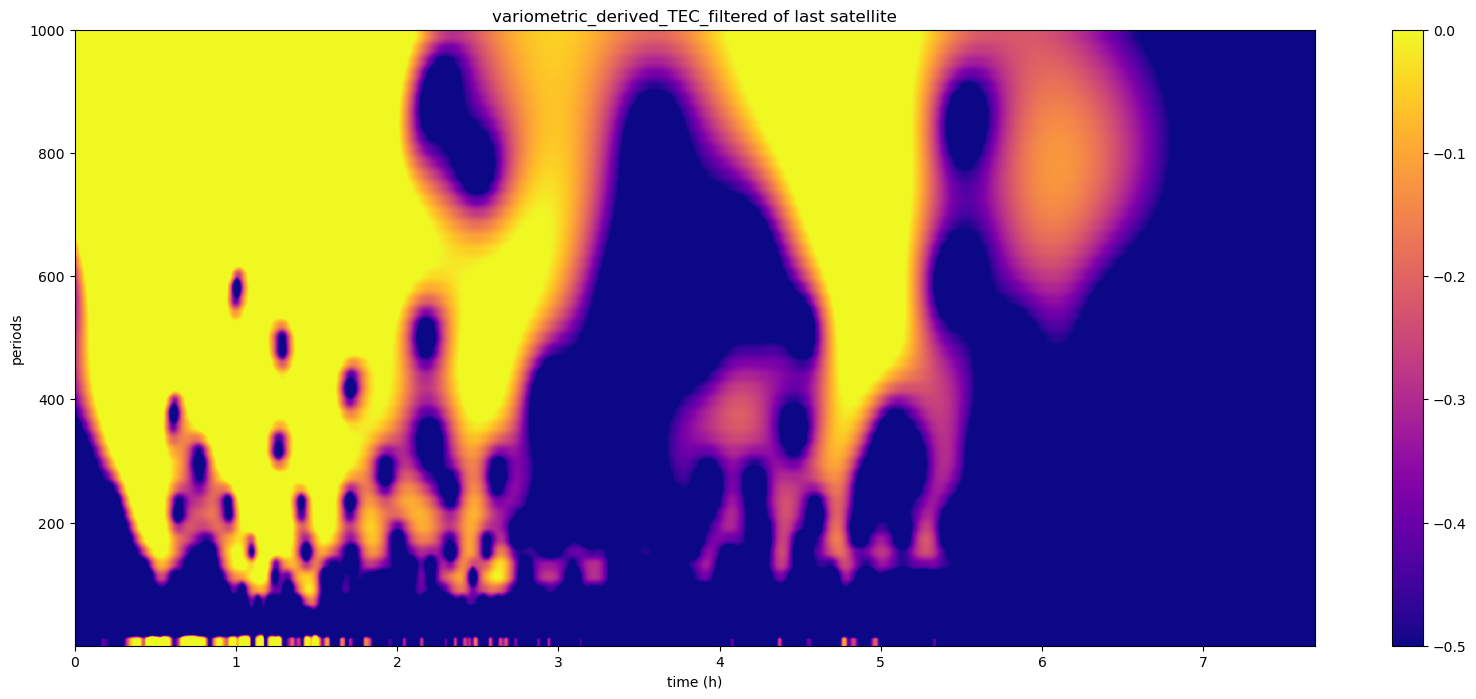

In [23]:
import scipy.signal as signal
# use the number of scales
# answer below
w = range(1,50)
freq = np.linspace(0.001, fs/2, 100)
cwtm = signal.cwt(last_sat, signal.morlet2, w)
fig3 = plt.figure(figsize=(20,8))
plt.imshow(np.log10(np.abs(cwtm)), extent=[0,(t.max()-t.min())/3600.,1./freq.max(),1./freq.min()], cmap='plasma', aspect='auto',
           vmax=0, vmin=-0.5, origin='lower')
plt.colorbar()
plt.xlabel('time (h)')
plt.ylabel('periods')
plt.title('variometric_derived_TEC_filtered of last satellite')
plt.show()

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

(answer below)

Periods ~100-1000 dominates the first ~2.5hours.
Periods ~400-1000 dominates 4-5 hours.

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc`` and ``NCM_SpatialGrid.nc``.


In the following we will prepare our data.

In [86]:
!pip install wget

  Using cached wget-3.2.zip (10 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=3180bce1248b7a653d8983596cf6805b328bdfd9cf7b63d1f060d7b62ac93904
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [25]:
# ansert below
import wget
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"

In [26]:
import netCDF4 as nc
import os

geologicGrid= nc.Dataset('NCM_GeologicFrameworkGrids.nc')
spatialGrid = nc.Dataset('NCM_SpatialGrid.nc')
aux_data = nc.Dataset('NCM_AuxData.nc')
geologicGrid

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim1(3201), dim2(4901), dim9(31)
    variables(dimensions): |S1 Notes(dim9), float32 Surface Elevation(dim2, dim1), float32 Bedrock Elevation(dim2, dim1), float32 Bottom Cenozoic Elevation(dim2, dim1), float32 Bottom Phanerozoic Elevation(dim2, dim1), float32 Mid Crustal Elevation(dim2, dim1), float32 Moho Elevation(dim2, dim1), float32 Top Ocean Plate Elevation(dim2, dim1)
    groups: 

**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``. Use ``contourf``,``x`` and ``y`` as lat-long variables. You can use ``levels``  to split the color map, and ``alpha`` less than 1 to increase transparency.

In [27]:
# answer below
x = spatialGrid['x'][0:4901, 0:3201]
y = spatialGrid['y'][0:4901, 0:3201]
elevation = geologicGrid['Surface Elevation'][0:4901, 0:3201]
WT = aux_data['Water Table Depth'][0:4901, 0:3201]

Text(0.5, 1.0, 'Water Table Depth and Surface Elevation')

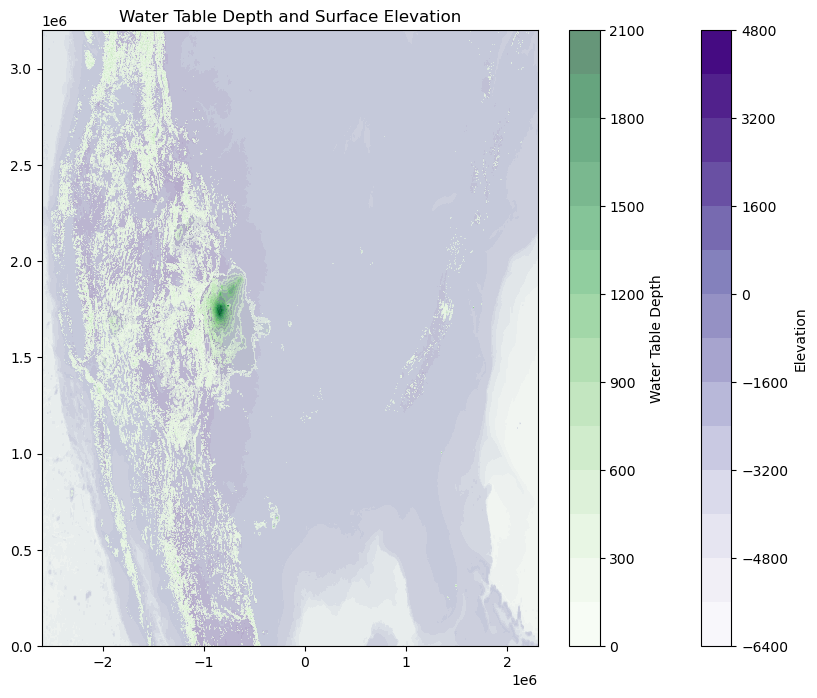

In [28]:
# plot below
fig4 = plt.figure(figsize=(10,8))
elevation_plot = plt.contourf(x, y, elevation, levels = 15, cmap = 'Purples')
WT_plot = plt.contourf(x, y, WT, levels = 15, cmap = 'Greens', alpha = 0.6)
colorbar_elev = fig4.colorbar(elevation_plot)
colorbar_elev.set_label('Elevation')
colorbar_WT = fig4.colorbar(WT_plot)
colorbar_WT.set_label('Water Table Depth')
plt.title('Water Table Depth and Surface Elevation')

**b. Perform and plot the 2D Fourier transforms (4 points)**

this is about the spatial sampling of the model  1.50073976128  km
this is about the spatial sampling of the model  1.07773444131  km


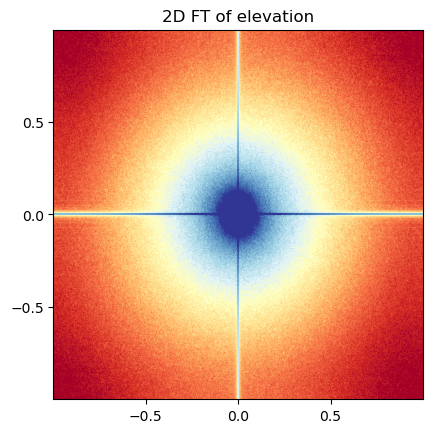

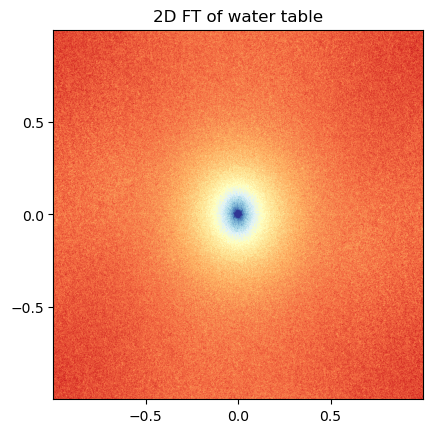

In [31]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift
import matplotlib.cm as cm

Zel = fft2(elevation)
Zwt = fft2(WT)

minlat,maxlat = min(spatialGrid['Latitude vector'][:]),max(spatialGrid['Latitude vector'][:])
minlon,maxlon = min(spatialGrid['Longitude vector'][:]),max(spatialGrid['Longitude vector'][:])
xlat = np.linspace(minlat,maxlat,3201)
xlon = np.linspace(minlon,maxlon,4901)

Rlon = (xlon-np.min(xlon))*111.25  # convert degrees to kms
drlon = Rlon[1]-Rlon[0]
print("this is about the spatial sampling of the model ",drlon," km")
klon = (fftfreq( 4901//2 , drlon  ))

Rlat = (xlat-np.min(xlat))*111.25  # convert degrees to kms
drlat = Rlat[1]-Rlat[0]
print("this is about the spatial sampling of the model ",drlat," km")
klat = (fftfreq( 3201//2 , drlat  ))

plt.imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
plt.title('2D FT of elevation')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.xticks([-0.5,0,0.5])
plt.yticks([-0.5,0,0.5])
plt.show()

plt.imshow(fftshift(np.log10(np.abs(Zwt)/Zwt.size)),vmin=-3, vmax=-1, cmap='RdYlBu',extent=[-1,1,-1,1])
plt.title('2D FT of water table')
x_label_list = ['-1/3 km$^{-1}$','0','1/3  km$^{-1}$']
plt.xticks([-0.5,0,0.5])
plt.yticks([-0.5,0,0.5])
plt.show()

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

Based on the 2D FT of elevation and water table, the wavelength that dominates in elevation is larger than that dominates in water table 

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

In [32]:
# solution
import scipy.signal as signal
from scipy.signal import butter,buttord,  sosfiltfilt, freqs

sos = signal.butter(2,0.01, btype='lp', output='sos')
Zel_lowpass = signal.sosfiltfilt(sos, Zel)
Zwt_lowpass = signal.sosfiltfilt(sos, Zwt)

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [33]:
# Sort the Fourier coefficients
Zsort = np.sort(np.abs(np.abs(Zel).reshape(-1)))

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

We are keeping up to 0.100000 the number of Fourier coefficients


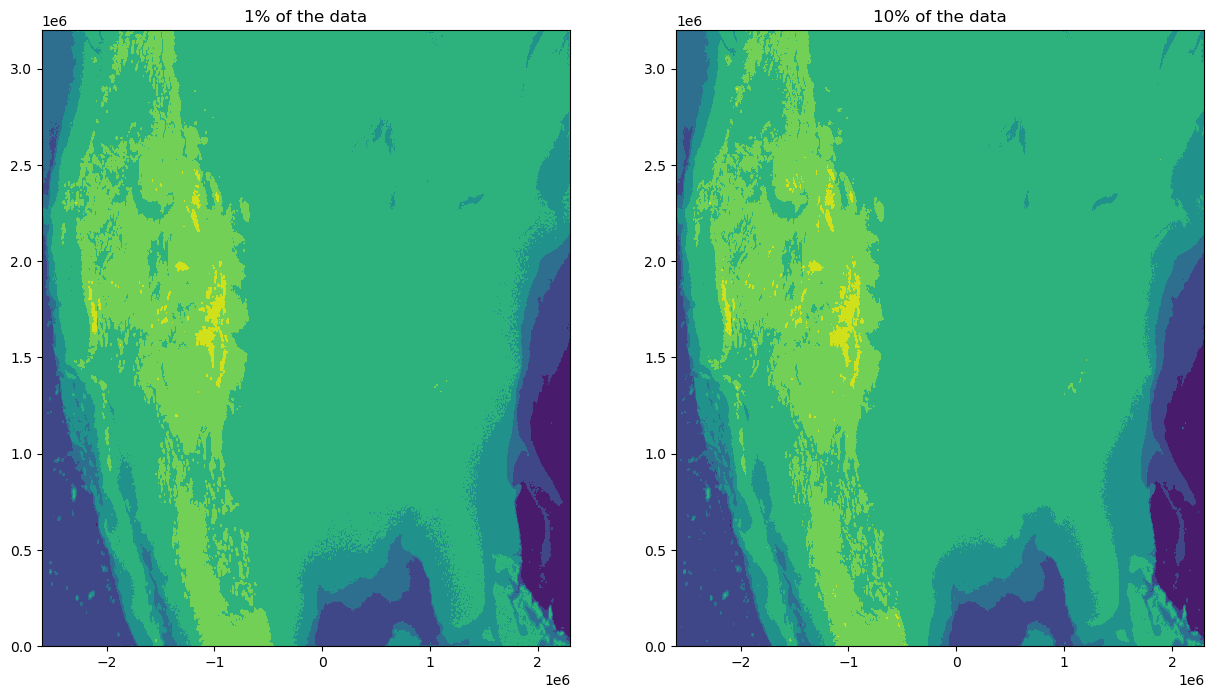

In [35]:

#snwer below
from scipy.fftpack import fft2, fftfreq,fftshift,ifft2
from IPython import display

fig5 = plt.figure(figsize=(15,8))

keep=0.01
display.clear_output(wait=True)
thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
ind = np.abs(Zel)>thresh
Atlow = Zel * ind 
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real
plt.subplot(1,2,1)
plt.title('1% of the data')
plt.contourf(x, y, Alow)


keep=0.1
display.clear_output(wait=True)
thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
ind = np.abs(Zel)>thresh
Atlow = Zel * ind 
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real
plt.subplot(1,2,2)
plt.title('10% of the data')
plt.contourf(x, y, Alow)


Now we will compare the original 2D data set with the Fourier compressed data


We are keeping up to 0.100000 the number of Fourier coefficients


Text(0.5, 1.0, 'Compressed data')

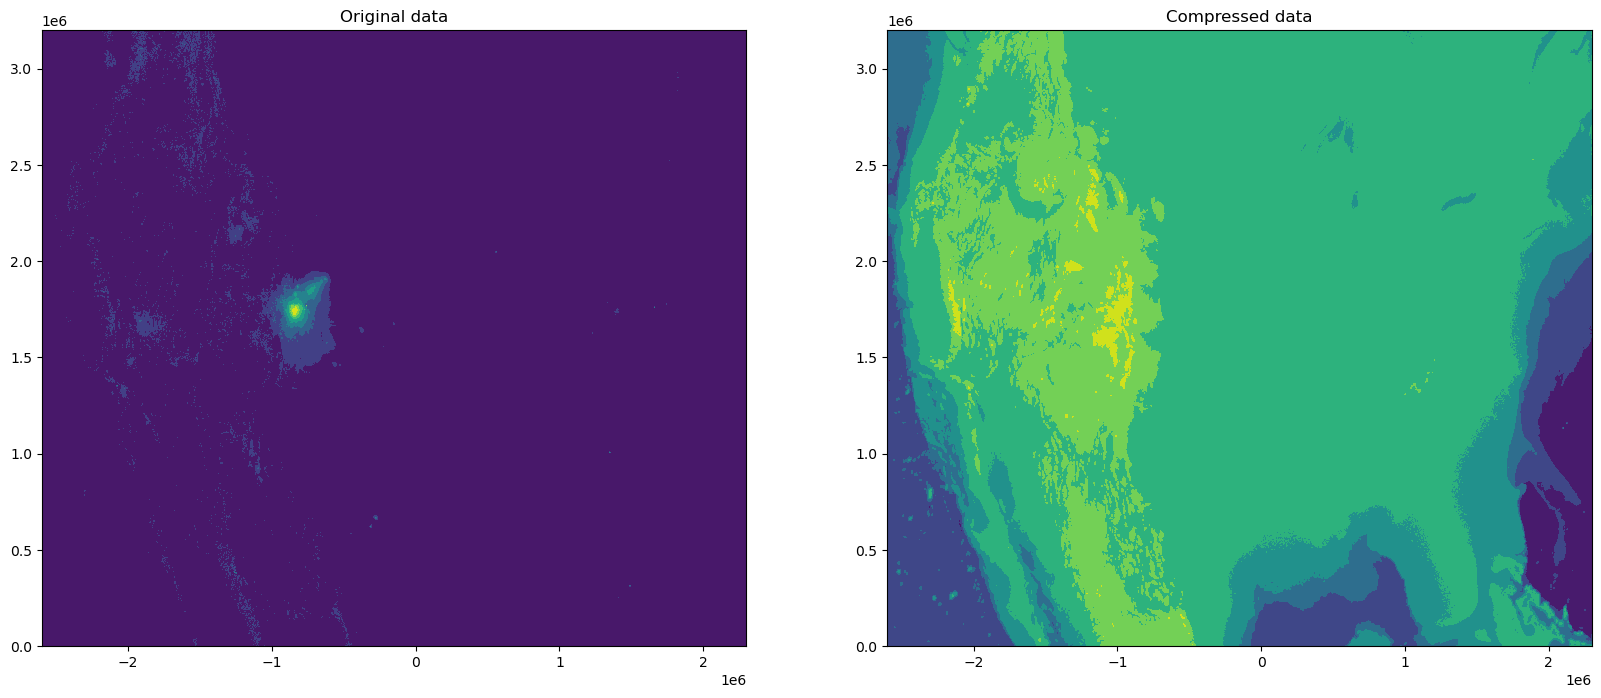

In [14]:
# answer below
keep=0.1
display.clear_output(wait=True)
thresh = Zsort[int(np.floor( (1-keep)*len(Zsort) ))]
ind = np.abs(Zel)>thresh
Atlow = Zel * ind 
print("We are keeping up to %f the number of Fourier coefficients" % keep)
Alow = ifft2(Atlow).real
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].contourf(x, y, WT)
ax[0].set_title('Original data')
ax[1].contourf(x, y, Alow)
ax[1].set_title('Compressed data')